# Deep Learning (AI5100)
## Assignment 2: <i>Convolutional Neural Networks</i>

<b>Name</b> - Sayanta Adhikari </br>
<b>Roll No</b> - AI22MTECH12005

#### Problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
np.random.seed(33)

The shape of the image is : (224, 224, 3)
The image is : 


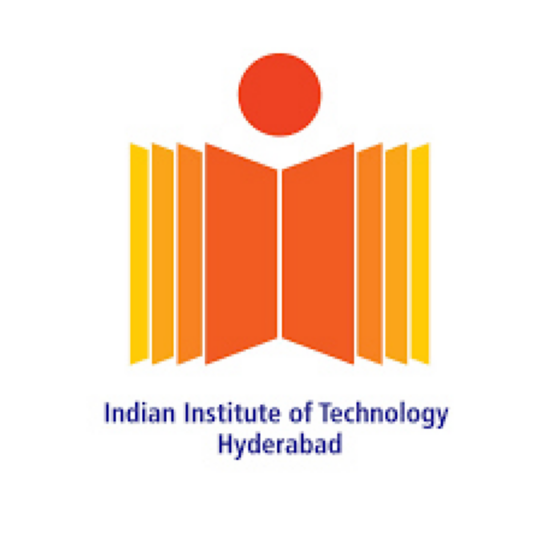

In [38]:
# Reading the IITH Logo Image

image = plt.imread('iith.jpg')
image = image[:-1, :-1, :3]
print(f"The shape of the image is : {image.shape}")
print("The image is : ")
plt.xticks([]); plt.yticks([])
plt.imshow(image)
plt.show()

1. Convolution Function

In [31]:
# Activation functions

def sigmoid(X: np.ndarray) -> np.ndarray:
    return 1/(1 + np.exp(-1 * X))

def tanh(X: np.ndarray) -> np.ndarray:
    return (np.exp(2 * X) - 1 ) / (np.exp(2 * X) + 1 )

def relu(X: np.ndarray) -> np.ndarray:
    return X * (X > 0)

def prelu(X: np.ndarray, a: float = 0.02) -> np.ndarray:
    return X * (X > 0) + a * X * (X <= 0)

# Padding function

def padding(img: np.ndarray, pad: int, pad_type: str) -> np.ndarray:
    n, m, c = img.shape
    if pad_type == 'zero':
        img_new = np.zeros([n + 2*pad, m + 2*pad, c])
        img_new[pad: -pad, pad: -pad, :] = img
        return img_new
    if pad_type == 'mirror':
        img_new = np.zeros([n + 2*pad, m + 2*pad, c])
        img_new[pad: -pad, pad: -pad, :] = img
        img_new[pad: -pad, 0: pad, :] = img[:, 0: pad, :]
        img_new[pad: -pad, -pad: , :] = img[:, -pad: , :]
        img_new[0: pad, pad: -pad, :] = img[0: pad, :, :]
        img_new[-pad: , pad: -pad, :] = img[-pad: , :, :]
        return img_new

In [32]:
# Convolution function

def convolution(img: np.ndarray, filter: np.ndarray, stride: int, pad: int, pad_type: str, activation_fn: str) -> np.ndarray:
    # Default values
    ACTIVATION_FN = {'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh, 'prelu': prelu}
    PAD_TYPE = {'zero', 'mirror', 'none'}

    # Parameter Checks
    if activation_fn not in ACTIVATION_FN.keys():
        raise ValueError("convolution: activation_fn must be one of %r ." % ACTIVATION_FN)
    if pad_type not in PAD_TYPE:
        raise ValueError("convolution: pad_type must be one of %r ." % PAD_TYPE)

    n, m, c_i = img.shape ; k1, k2, c_f = filter.shape

    if k1 % 2 == 0 or k2 % 2 == 0:
        raise ValueError("convolution: filter shape dimensions must be odd.")
    if c_i != c_f:
        raise ValueError("convolution: img and filter channel dimension must match.")
    if (n + 2* pad - k1)/stride != (n + 2* pad - k1)//stride:
        raise ValueError("convolution: (img.shape[0] + 2*pad - filter.shape[0])/stride must be an integer.")
    if (m + 2* pad - k2)/stride != (m + 2* pad - k2)//stride:
        raise ValueError("convolution: (img.shape[1] + 2*pad - filter.shape[1])/stride must be an integer.")

    # Applying padding
    if pad_type != 'none':
        img = padding(img, pad, pad_type)
        n = n + 2*pad; m = m + 2*pad

    s1 = n - k1 + stride; s2 = m - k2 + stride

    # Performing convolution
    activation = np.zeros([s1//stride, s2//stride])
    k = 0
    for i in range(k1//2, s1, stride):
        l = 0
        for j in range(k2//2, s2, stride):
            temp = img[i - k1//2: i + k1//2 + 1, j - k2//2: j + k2//2 + 1, :] * filter
            activation[k, l] = np.sum(temp)
            l +=1
        k += 1
    return ACTIVATION_FN[activation_fn](activation)

The shape of the kernel is: (3, 3, 3)
The filter is: 


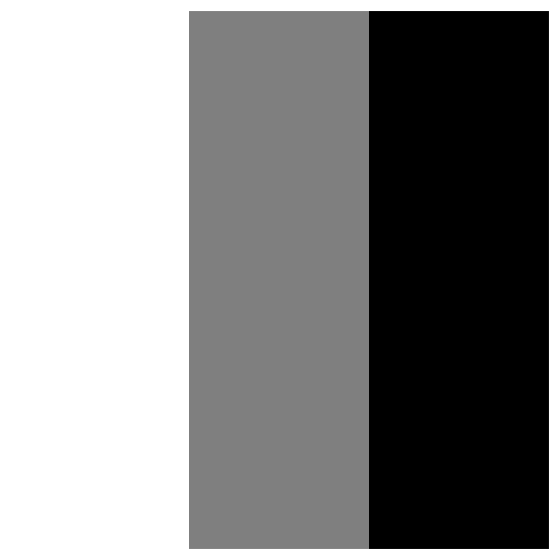

In [33]:
kernel = np.repeat(np.array([[[1], [0], [-1]], [[1], [0], [-1]], [[1], [0], [-1]]]), repeats=3, axis=2)
print(f"The shape of the kernel is: {kernel.shape}")
print("The filter is: ")
plt.xticks([]); plt.yticks([])
plt.imshow((kernel + 1) * 255//2)
plt.show()

The shape of the activation after convolution is: (222, 222)
The activation map is : 


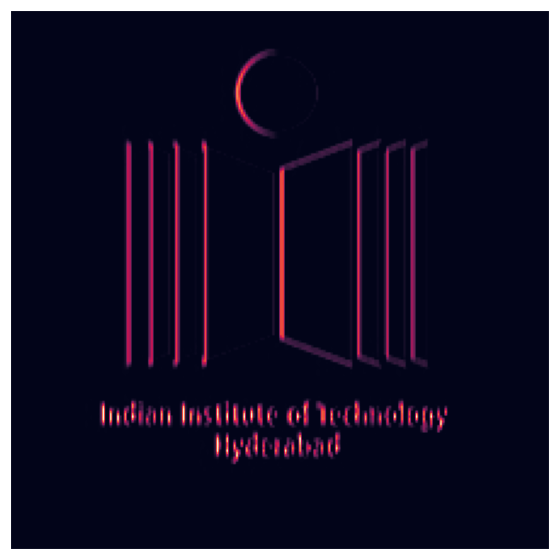

In [34]:
# Preforming Convolution

activation = convolution(img=image, filter=kernel, stride=1, pad=0, pad_type='none', activation_fn='relu')
print(f"The shape of the activation after convolution is: {activation.shape}")
print("The activation map is : ")
plt.xticks([]); plt.yticks([])
plt.imshow(activation)
plt.show()

2. Pooling Function

In [35]:
# Helper function for pooling function

def _pooling(img: np.ndarray, pool_type: str) -> np.ndarray:
    if pool_type == 'max':
        return np.max(np.max(img, axis=0),axis=0)
    if pool_type == 'min':
        return np.min(np.min(img, axis=0),axis=0)
    if pool_type == 'avg':
        return np.average(np.average(img, axis=0),axis=0)

In [36]:
# Pooling Function

def pooling(img: np.ndarray, pool_type: str, stride: int = None, pool: "list[int]" = None) -> np.ndarray:
    # Default Values
    POOL_TYPE = {'max', 'min', 'avg' , 'GAP'}

    # Parameter checks
    if pool_type not in POOL_TYPE:
        raise ValueError("pooling: pool_type must be one of %r ." % POOL_TYPE)

    n, m = img.shape

    # If pool filter size is not provided then it considers the stride as pool filter dimension
    if pool == None:
        pool1 = pool2 = stride
    elif len(pool) == 1:
        pool1 = pool2 = pool[0]
    elif len(pool) == 2:
        pool1 = pool[0]; pool2 = pool[1]
    else:
        raise ValueError("pooling: length of pool must be less than or equal to 2")

    if stride != None and (n - pool1)/stride != (n - pool1)//stride:
        raise ValueError("pooling: (image.shape[0] - pool)/stride must be an integer")

    if stride != None and (m - pool2)/stride != (m - pool2)//stride:
        raise ValueError("pooling: (image.shape[1] - pool)/stride must be an integer")
    
    # Performing pooling
    if pool_type != 'GAP':
        s1 = (n - pool1 + stride)//stride; s2 = (m - pool2 + stride)//stride
        output = np.zeros([s1, s2])
        k = 0
        for i in range(0, n - pool1 + 1, stride):
            l = 0
            for j in range(0, m - pool2 + 1, stride):
                output[k, l] = _pooling(img[i: i+pool1+1, j: j+pool2+1], pool_type)
                l += 1
            k +=1
        return output
    else:
        return _pooling(img, 'avg').reshape(1, 1)

The shape of the activation after pooling: (111, 111)
The activation map is: 


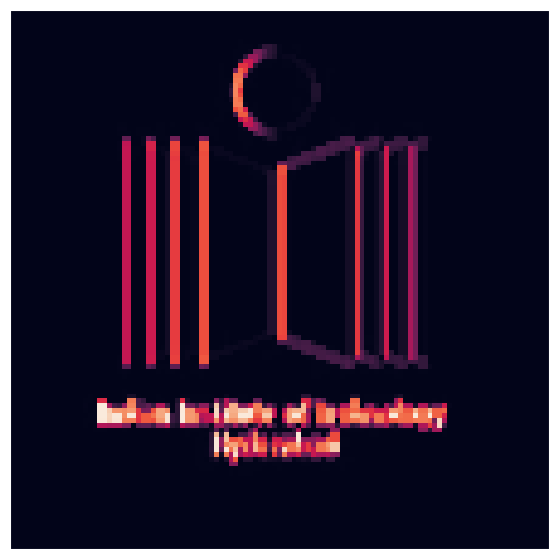

In [37]:
# Performing pooling on the activation

pool_activation = pooling(img=activation, pool_type='max', stride=2, pool=[2, 2])
print(f"The shape of the activation after pooling: {pool_activation.shape}")
print("The activation map is: ")
plt.xticks([]); plt.yticks([])
plt.imshow(pool_activation)
plt.show()

3. Convolution Layer Function

In [39]:
# Convolution Layer Function

def conv2D(img: np.ndarray, n_filters: int, dim_filter: int, stride: int, pad_type: str, activation_fn: str, pad: int = 0) -> np.ndarray:
    c = img.shape[-1]
    activation_list = []
    for _ in range(n_filters):
        filteR = np.random.rand(dim_filter, dim_filter, c)
        activation_list.append(convolution(img, filteR, stride, pad, pad_type, activation_fn))
    return np.stack(activation_list, axis=-1)

In [40]:
# Performing the operation of a convolutional layer

activation_stack = conv2D(img=image, n_filters=18, dim_filter=3, pad_type='none', pad=0, stride=1, activation_fn='relu')
print(f"The image sige is {image.shape}")
print(f"The activation map after conv2D is : {activation_stack.shape}")

The image sige is (224, 224, 3)
The activation map after conv2D is : (222, 222, 18)


4. Pooling Layer Function

In [42]:
# Pooling layer Function

def pool2D(img: np.ndarray, pool_type: str, stride: int = None, pool: "list[int]" = None):
    c = img.shape[-1]; pool_list = []
    for i in range(c):
        pool_list.append(pooling(img=img[:, :, i], pool_type=pool_type, stride=stride, pool=pool))
    return np.stack(pool_list, axis=-1)

In [43]:
# Performing the operation for a pooling layer

pool_activation_stack = pool2D(img=activation_stack, stride=2, pool_type='min', pool=[2, 2])
print(f"The activation map size before is {activation_stack.shape}")
print(f"The activation map after pool2D is : {pool_activation_stack.shape}")

The activation map size before is (222, 222, 18)
The activation map after pool2D is : (111, 111, 18)


5. Flattening Function

In [44]:
# Flattenting (unraveling) function

def flatten(input: np.ndarray, out_dim: int) -> np.ndarray:
    flat_in = input.reshape(-1, 1)
    in_dim = flat_in.shape[0]
    weights, bias = np.random.rand(in_dim, out_dim), np.random.rand(out_dim, 1)
    output = weights.T @ flat_in + bias
    return output

In [45]:
# Performing flattening

act = flatten(input=pool_activation_stack, out_dim=254)
print(f"The activation map size before is {pool_activation_stack.shape}")
print(f"The activation map after flatten is : {act.shape}")

The activation map size before is (111, 111, 18)
The activation map after flatten is : (254, 1)


6. Multilayer Perceptron (MLP) function

In [50]:
# Softmax Function Implemented

def softmax(x: np.ndarray) -> np.ndarray:
    out = np.exp2(x)
    return out/np.sum(out)

In [51]:
# Multilayer Perceptron Function

def MLP(input: np.ndarray, hid_dim: "list[int]", activation_fn: str, do_softmax: bool = True) -> np.ndarray:
    # Default Values
    ACTIVATION_FN = {'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh, 'prelu': prelu}

    # Parameter Checks
    if activation_fn not in ACTIVATION_FN.keys():
        raise ValueError("MLP: activation_fn must be one of %r ." % ACTIVATION_FN)
    
    n = len(input)
    layers = [n] + hid_dim

    # Initializing weights and biases as random
    weights = [np.random.rand(layers[i], layers[i+1]) for i in range(len(layers) - 1)]
    biases = [np.random.rand(layers[i+1], 1) for i in range(len(layers) - 1)]

    # Doing a forward pass for MLP
    out = input
    for i in range(len(weights) - 1):
        out = weights[i].T @ out + biases[i]
        out = ACTIVATION_FN[activation_fn](out)
        
    out = weights[-1].T @ out + biases[-1]

    if do_softmax:
        return softmax(out)
    return out

In [53]:
# Performing MLP

act2 = MLP(input=act, hid_dim=[128, 56, 24, 10], activation_fn='sigmoid', do_softmax=True)
print(f"The activation map size before is {act.shape}")
print(f"The activation map after MLP is : {act2.shape}")

The activation map size before is (254, 1)
The activation map after MLP is : (10, 1)


7. Feed-forward path

In [58]:
# Downloading CIFAR-10 Dataset

import tarfile
file = tarfile.open('cifar-10-python.tar.gz')
file.extractall('./cifar')
file.close()

def unpickle(file: str) -> dict:
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_dict = unpickle('cifar/cifar-10-batches-py/data_batch_1')
test_img = data_dict[b'data'][20, :].reshape((32, 32, 3), order = 'F')

In [56]:
def CNN(img: np.ndarray, do_softmax: bool = True) -> np.ndarray:
    
    out1 = conv2D(img=img, n_filters=16, dim_filter=3, pad_type='zero', stride=1, activation_fn='sigmoid', pad=1)
    out2 = pool2D(img=out1, stride=2, pool_type='max', pool=[2, 2])
    out3 = conv2D(img=out2, n_filters=8, dim_filter=3, stride=1, pad_type='none', activation_fn='sigmoid')
    out4 = pool2D(img=out3, stride=2, pool_type='max', pool=[2, 2])
    out5 = pool2D(img=out4, pool_type='GAP')
    n, m, c = out5.shape
    out6 = flatten(input=out5, out_dim=n*m*c)
    out7 = MLP(input=out6, hid_dim=[n*m*c, 10], activation_fn='sigmoid', do_softmax=do_softmax)
    return out7

The image is :


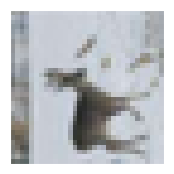

In [67]:
# Applying the forward pass

print("The image is :")
plt.figure(figsize=(2, 2))
plt.xticks([]); plt.yticks([])
plt.imshow(test_img)
plt.show()

In [64]:
out_with_softmax = CNN(img=test_img, do_softmax=True)
out_without_softmax = CNN(img=test_img, do_softmax=False)
print(f"The imput shape is {test_img.shape}")
print(f"The output shape is {out_with_softmax.shape}")

The imput shape is (32, 32, 3)
The output shape is (10, 1)


In [66]:
print("The output with softmax is  :")
print(out_with_softmax.reshape(-1, ))
print()
print("The output without softmax is  :")
print(out_without_softmax.reshape(-1, ))

The output with softmax is  :
[0.05944455 0.10217332 0.12566871 0.11827907 0.10652026 0.13925588
 0.12174823 0.12216655 0.06182404 0.04291938]

The output without softmax is  :
[4.65257827 4.0791238  5.07000277 4.46336926 4.40766598 5.04950642
 4.48275521 3.57180191 4.69969636 5.0173219 ]


8. (a)  Choose an image from each of the 10 classes and display the output vector for each case. Do
you see any trend in the output vectors?